# Figure 4

Effect size vs. behavioral data

In [1]:
from pathlib import Path

import colorcet as cc
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from cycler import cycler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import analysis
from metadata import METADATA

In [2]:
# Register tqdm with pandas for `progress_apply`
tqdm.pandas()

In [3]:
matplotlib.rcParams.update({'font.size': 16})

# Color palette
PALETTE = np.array(cc.b_glasbey_category10[:5])[
    [2, 4, 0, 1, 3]
]
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', PALETTE)

In [4]:
OUTPUT_DIR = Path('figures')

## Load data

In [5]:
main = pd.read_parquet("results/main.parquet")

In [6]:
# Unscrambled vs. scrambled
subset = main.loc[
    main["stimulus_is_scrambled_pair"]
]
subset.shape

(2200, 33)

In [7]:
behavior = (
    pd.read_parquet('results/behavior_by_session.parquet')
    .merge(METADATA, on='session')
    .rename(columns={
        "normalized_pupil_diameter": "pupil diameter",
        "locomotion": "locomotion fraction",
    })
)

## Effect size

In [8]:
a = 'natural'
b = 'artificial'
label_col = 'stimulus_type'

### Within session

In [9]:
response = "log(normalized differentiation)"

In [10]:
effect_size = (
    subset
    .groupby("session")
    .progress_apply(
        analysis.cohens_d,
        a=a,
        b=b,
        value_col=response,
        label_col=label_col,
    )
)

  0%|          | 0/44 [00:00<?, ?it/s]

In [11]:
effect_size.to_parquet("results/effect_size.parquet")

In [12]:
subset = subset.merge(effect_size, on="session")

In [13]:
main_effect_subset = subset.loc[
    (subset.layer == 'L2/3') &
    (subset.area.isin(['AL', 'AM'])),
]

Range of effect sizes within L2/3 AL & AM

In [14]:
main_effect_subset["Cohen's d"].min()

0.570463021403664

In [15]:
main_effect_subset["Cohen's d"].max()

1.2576662902423894

### Effect size across L2/3 AL & AM sessions, 

In [16]:
analysis.cohens_d(
    main_effect_subset,
    a=a,
    b=b,
    value_col=response,
    label_col=label_col,
)

mean difference    0.240340
Cohen's d          0.340766
dtype: float64

## Plot

In [17]:
behavior = behavior.merge(effect_size, on='session')

In [18]:
behavior_subset = behavior.loc[
    (behavior['layer'] == 'L2/3') &
    behavior['area'].isin(['AL', 'AM'])
]

In [19]:
output_dir = OUTPUT_DIR / "fig_4"

In [20]:
y = "Cohen's d"

In [21]:
def scatter(ax, x, y, data, **kwargs):
    kwargs = {
        **dict(
            hue="area",
            style="layer",
            s=100,
            alpha=0.75,
            edgecolor=None,
            markers={
                "L2/3": "o",
                "L4": "s",
                "L5": "^",
            },
            hue_order=[
                "V1",
                "LM",
                "AL",
                "PM",
                "AM",
            ],
        ),
        **kwargs,
    }
    return sb.scatterplot(ax=ax, x=x, y=y, data=data, **kwargs)

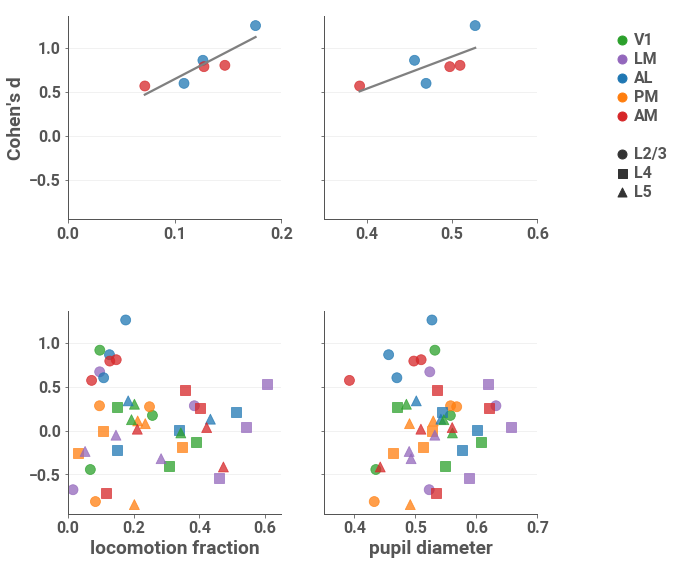

In [22]:
figsize = (8, 8)
fig, ax = plt.subplots(2, 2, sharey=True, figsize=figsize)

sb.regplot(
    ax=ax[0, 0],
    color="grey",
    ci=None,
    scatter=False,
    x="locomotion fraction",
    y=y,
    data=behavior_subset,
)
sb.regplot(
    ax=ax[0, 1],
    color="grey",
    ci=None,
    scatter=False,
    x="pupil diameter",
    y=y,
    data=behavior_subset,
)

scatter(ax=ax[0, 0], x="locomotion fraction", y=y, data=behavior_subset)
scatter(ax=ax[0, 1], x="pupil diameter", y=y, data=behavior_subset)
scatter(ax=ax[1, 0], x="locomotion fraction", y=y, data=behavior)
scatter(ax=ax[1, 1], x="pupil diameter", y=y, data=behavior)

for axis in ax[0]:
    axis.set_xlabel(None)

for axis in ax[:, 1]:
    axis.set_ylabel(None)
ax[1, 0].set_ylabel(None)

for axis in ax.flat:
    axis.get_legend().remove()

ax[0, 0].set_xlim(0, 0.2)
ax[0, 0].set_xticks([0, 0.1, 0.2])
ax[1, 0].set_xlim(0, 0.65)
ax[1, 0].set_xticks([0, 0.2, 0.4, 0.6])
ax[0, 1].set_xlim(0.35, 0.55)
ax[0, 1].set_xticks([0.4, 0.5, 0.6])
ax[1, 1].set_xlim(0.35, 0.7)
ax[1, 1].set_xticks([0.4, 0.5, 0.6, 0.7])

handles, labels = ax[1, 1].get_legend_handles_labels()
labels[0] = ""
labels[-4] = ""
legend = fig.legend(
    handles=handles,
    labels=labels,
    bbox_to_anchor=(1.2, 1),
    labelspacing=0.25,
    markerscale=1.5,
    ncol=1,
    handletextpad=-0.25,
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.45, wspace=0.2)

# Write to disk
analysis.savefig(
    fig,
    output_dir / "effect_size_vs_behavior",
    bbox_extra_artists=[legend],
)

fig.show()

## Statistical tests

### Set up R and prepare data

In [23]:
%load_ext rpy2.ipython

In [24]:
data = behavior.loc[:, [
    "Cohen's d",
    "area",
    "layer",
    "pupil diameter",
    "locomotion fraction",
]].rename(columns={
    "Cohen's d": 'cohens_d',
    "locomotion fraction": 'locomotion_fraction',
    "pupil diameter": 'pupil_diameter',
})

In [25]:
data_subset = data.loc[
    (data['layer'] == 'L2/3') &
    (data['area'].isin(['AL', 'AM']))
]

### Test

In [26]:
%%R -i data_subset

cor.test(
    data_subset$locomotion_fraction, 
    data_subset$cohens_d, 
    method = 'pearson',
    alternative = "two.sided",
)


	Pearson's product-moment correlation

data:  data_subset$locomotion_fraction and data_subset$cohens_d
t = 4.0296, df = 4, p-value = 0.01574
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3082942 0.9886237
sample estimates:
      cor 
0.8957413 



In [27]:
%%R -i data_subset

cor.test(
    data_subset$pupil_diameter, 
    data_subset$cohens_d, 
    method = 'pearson',
    alternative = "two.sided", 
)


	Pearson's product-moment correlation

data:  data_subset$pupil_diameter and data_subset$cohens_d
t = 2.0537, df = 4, p-value = 0.1092
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2273095  0.9662081
sample estimates:
      cor 
0.7164124 

